## Modeling Beta as an OU Process
### 2024.08.07

In these first few cells, we generate data using a step-function beta. 
Beta starts at 0.25 for 40 days, and then steps down to 0.12 for the remainder of the time series.

See the first visualiation 'SIRH Dynamics' for the generated data. 

In [1]:
from src.particle_filter.parameters import ModelParameters
from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp
import numpy as np

days = 150
step_beta_switch = 50

initial_beta = 0.25
final_beta = 0.15

# Create a linear decline from initial_beta to final_beta
linear_decline = np.linspace(initial_beta, final_beta, step_beta_switch)

# Combine the declining part with the final constant value
step_beta = np.concatenate([linear_decline, [final_beta] * (days - step_beta_switch)])

pop = 100000
infected = 0.05 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)

In [2]:
print(step_beta)

[0.25       0.24795918 0.24591837 0.24387755 0.24183673 0.23979592
 0.2377551  0.23571429 0.23367347 0.23163265 0.22959184 0.22755102
 0.2255102  0.22346939 0.22142857 0.21938776 0.21734694 0.21530612
 0.21326531 0.21122449 0.20918367 0.20714286 0.20510204 0.20306122
 0.20102041 0.19897959 0.19693878 0.19489796 0.19285714 0.19081633
 0.18877551 0.18673469 0.18469388 0.18265306 0.18061224 0.17857143
 0.17653061 0.1744898  0.17244898 0.17040816 0.16836735 0.16632653
 0.16428571 0.1622449  0.16020408 0.15816327 0.15612245 0.15408163
 0.15204082 0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.1

In [3]:
import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]

In [4]:
def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state


for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))

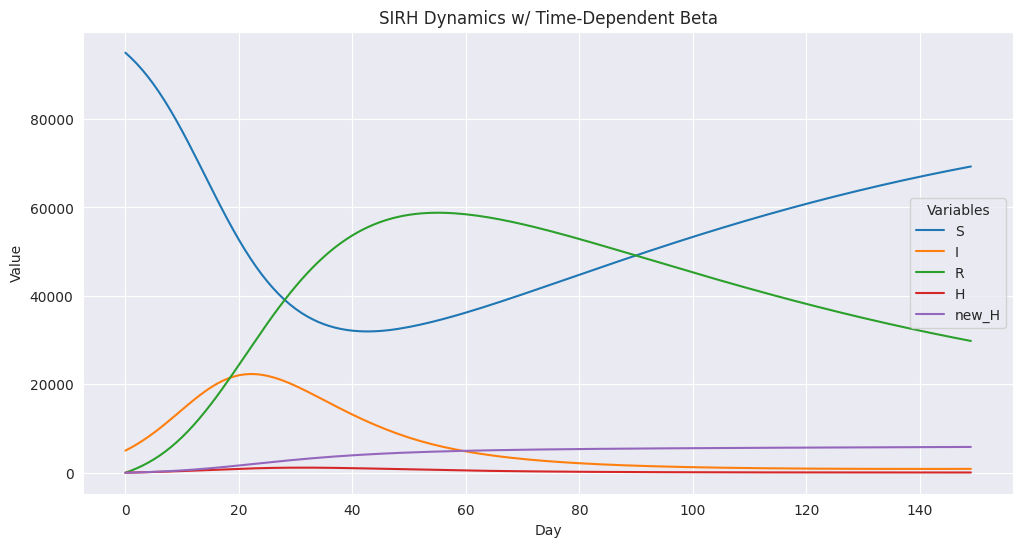

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1] - 1):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Dynamics w/ Time-Dependent Beta")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

In [6]:
# obs_data is an array of the new hospitalizations from synthetic data
print("new hospitalizations:", case_reports)

new hospitalizations: [0, 30.0, 34.066837310791016, 38.520259857177734, 43.35952377319336, 48.57415008544922, 54.14228820800781, 60.02939224243164, 66.18728637695312, 72.5539321899414, 79.05386352539062, 85.59960174560547, 92.09398651123047, 98.4333724975586, 104.51158905029297, 110.2242660522461, 115.47344970703125, 120.17178344726562, 124.24624633789062, 127.6408462524414, 130.31834411621094, 132.2606964111328, 133.4685516357422, 133.95957946777344, 133.7662811279297, 132.93324279785156, 131.51417541503906, 129.5690460205078, 127.16133117675781, 124.35560607910156, 121.21558380126953, 117.80253601074219, 114.1740493774414, 110.38327026367188, 106.4783935546875, 102.50243377685547, 98.49323272705078, 94.48357391357422, 90.50145721435547, 86.57042694091797, 82.7099609375, 78.93586730957031, 75.26068878173828, 71.694091796875, 68.24324798583984, 64.91315460205078, 61.70698165893555, 58.626338958740234, 55.671546936035156, 52.84184646606445, 50.1356086730957, 47.58399963378906, 45.179058

## Estimating Beta with our Particle Filter

We run a PF over the generated data. Settings were configured in `config.toml`.

- Beta prior = uniform draw from [0.1, 0.3]
- Number of particles = 300
- dt = 1.0
- infected compartment prior: uniform draw from [1, 0.08*population]
- normal logpdf likelihood with variable scale (10% of average particle estimate)
- dW_volatility = {value = 0.1, is_fixed = true}

#### Params for the beta OU process
- beta_theta = {value = 0.01, is_fixed = true}
- beta_mu = {value = 0.15, is_fixed = true}
- beta_sigma = {value=0.01, is_fixed = true}

In [7]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)

In [8]:
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [21:11<00:00,  8.47s/it]


In [9]:
true_data = np.array(det_output)
true_data = true_data.T
true_data[5, :] = step_beta
true_data.shape

(6, 150)

In [10]:
# Number of particles, state variables, and time steps
N, S, T = states.shape

state_labels = ["S", "I", "R", "H", "new_H", "beta"]

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

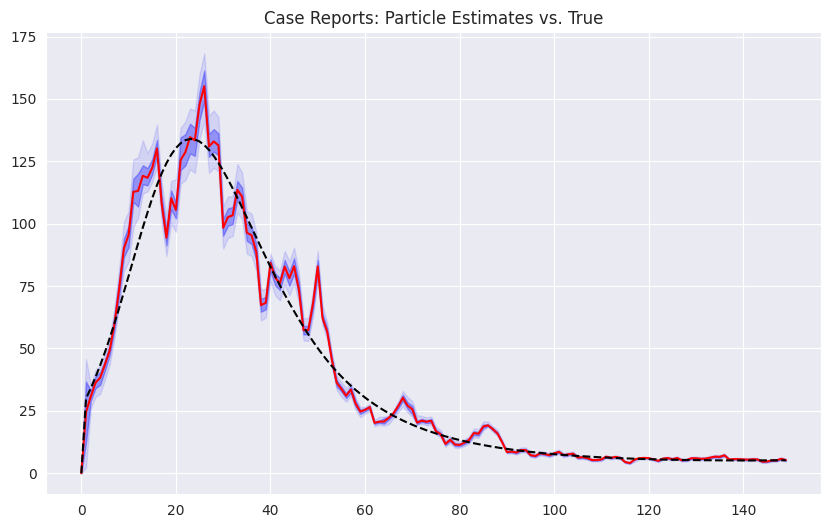

In [11]:
quantile_hosp_estimates = np.percentile(
    hosp_estimates, [q * 100 for q in quantiles], axis=0
)
plt.figure(figsize=(10, 6))
plt.title("Case Reports: Particle Estimates vs. True")
plt.fill_between(
    np.arange(T),
    quantile_hosp_estimates[0],
    quantile_hosp_estimates[-1],
    color="blue",
    alpha=0.1,
)
plt.fill_between(
    np.arange(T),
    quantile_hosp_estimates[1],
    quantile_hosp_estimates[-2],
    color="blue",
    alpha=0.3,
)
plt.plot(np.arange(T), quantile_hosp_estimates[2], color="red")  # Median
plt.plot(np.arange(T), case_reports, color="black", linestyle="--")  # true data

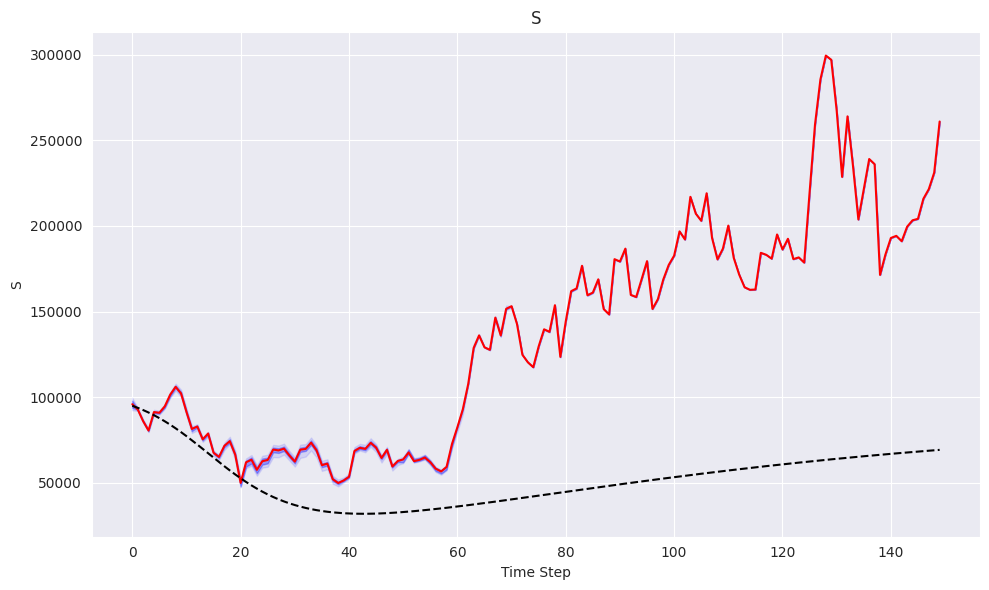

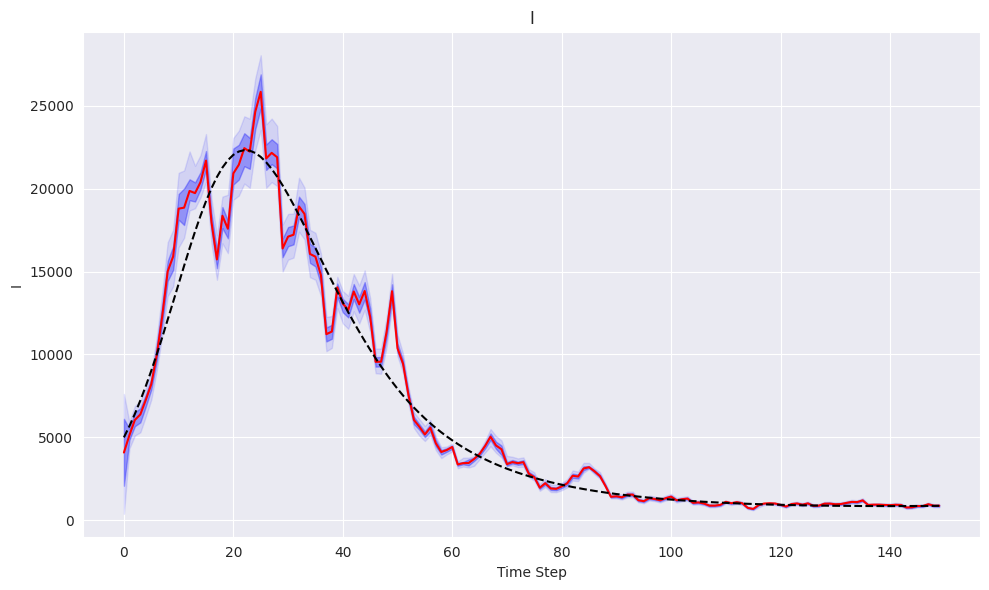

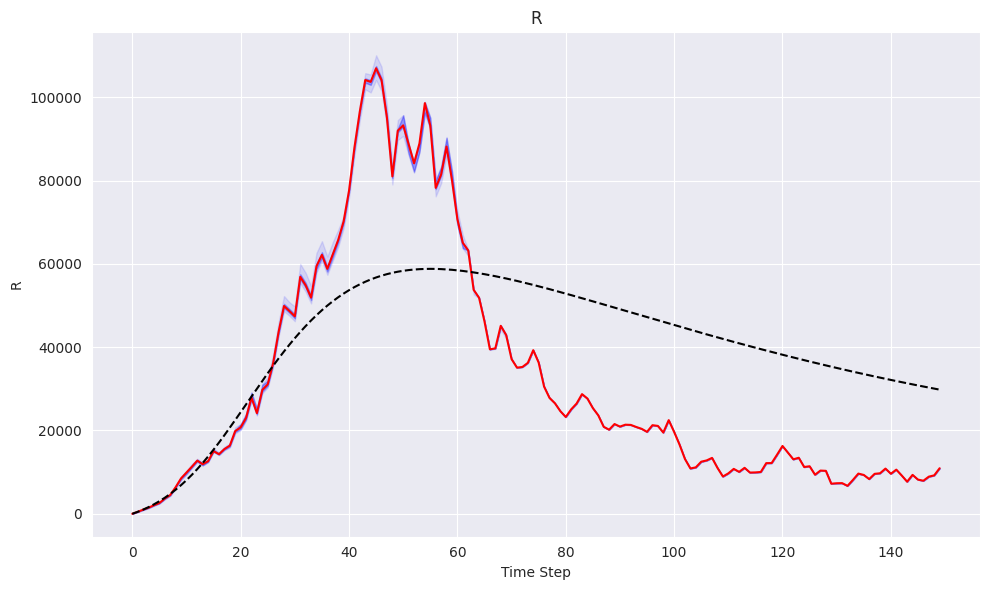

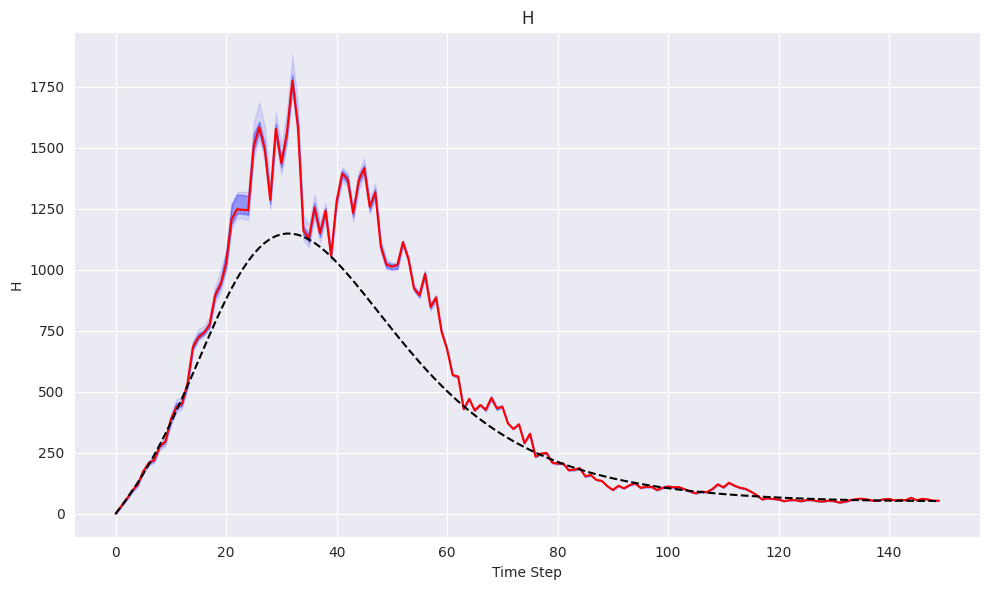

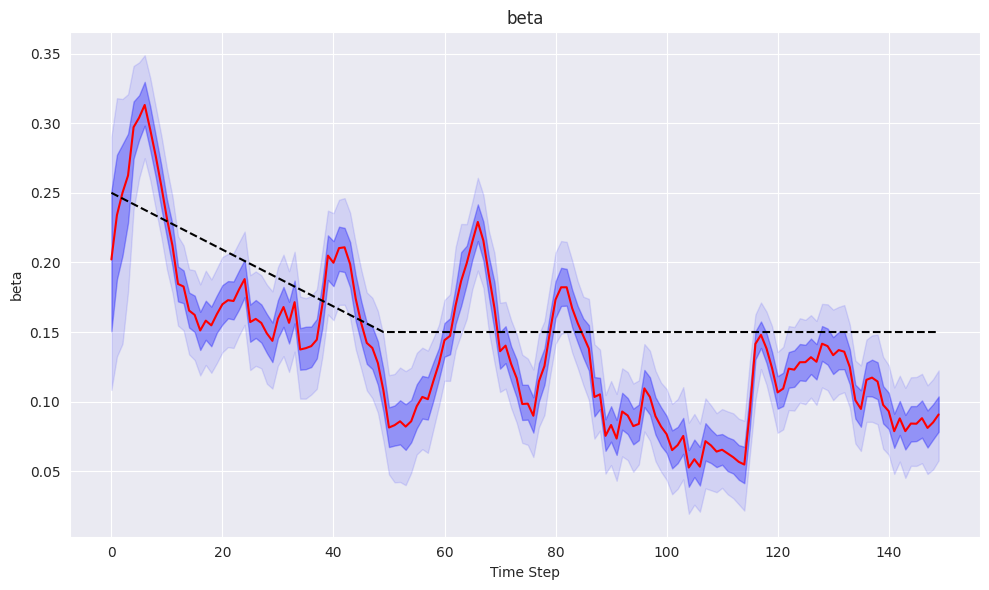

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot each state variable separately
for i in range(S):
    if i == 4:  # ignore new_H compartment
        continue

    variable_data = states[:, i, :]  # Shape (N, T)

    quantile_values = np.percentile(variable_data, [q * 100 for q in quantiles], axis=0)

    plt.figure(figsize=(10, 6))

    # Fill areas between quantiles
    plt.fill_between(
        np.arange(T), quantile_values[0], quantile_values[-1], color="blue", alpha=0.1
    )
    plt.fill_between(
        np.arange(T), quantile_values[1], quantile_values[-2], color="blue", alpha=0.3
    )
    plt.plot(np.arange(T), quantile_values[2], color="red")  # Median
    plt.plot(np.arange(T), true_data[i, :], color="black", linestyle="--")  # true data

    plt.title(state_labels[i])
    plt.xlabel("Time Step")
    plt.ylabel(state_labels[i])

    plt.tight_layout()
    plt.show()
    plt.close()

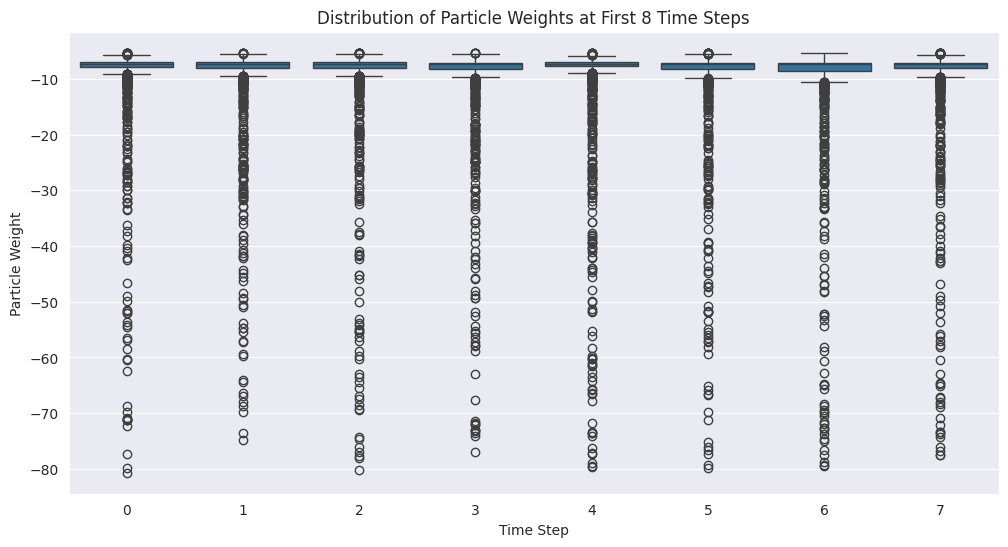

In [13]:
first_T = 8  # Number of time steps

first_T_weights = all_weights[:, 0:first_T]
# Create a DataFrame for seaborn
import pandas as pd

data = {
    "Weight": first_T_weights.flatten(),
    "Time Step": np.repeat(np.arange(first_T), N),
}
df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Time Step", y="Weight", data=df)
plt.title(f"Distribution of Particle Weights at First {first_T} Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Particle Weight")
plt.show()